# Initial Setup

In [2]:
!pip install torchinfo torchviz -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.2 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Tuple
import math
import time

from dataclasses import dataclass # decorator for classes with less boilerplate: Auto-generates __init__, __repr__, etc.
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F # Functional interface for operations (activations, pooling, etc.)
import torch.optim as optim  # Optimization algorithms (SGD, Adam, etc.)
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset  # DataLoader: Handles batching, shuffling, parallel loading. Dataset: Abstract class for custom datasets

from torchinfo import summary
from torchviz import make_dot



# autocast: Automatic Mixed Precision - uses float16 where possible to speed up training while maintaining float32 for operations that need precision
# GradScaler: Scales gradients to prevent underflow when using float16.  Essential for stable mixed precision training
from torch.cuda.amp import autocast, GradScaler

from functools import partial # Creates partial functions by fixing some arguments. Useful for creating customized functions from general ones




np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cpu
PyTorch version: 2.6.0+cu124


### Helper for Visualization of Attention

In [ ]:
def visualize_attention(attention_weights, tokens=None, title="Attention Weights"):
  """
  Visualize attetion weight matrix

  attention_weights: 2D tensor/array where element [i,j] shows how much
                    query position i attends to key position j
  tokens: Optional list of token strings for axis labels
  title: Plot title

  Attention weights show which parts of input the model focuses on
  Darker colors = higher attention scores
  """

  plt.figure(figsize=(10,8))

  sns.heatmap(
      attention_weights,
      cmap="Blues",
      cbar=True,
      square=True,
      xticklabels=tokens if tokens else False,
      yticklabels=tokens if tokens else False
  )
  plt.title(title)
  plt.xlabel("Keys")
  plt.ylabel("Queries")
  plt.show()


# Simplified Dot-Product Attention (Vanilla)

In [ ]:
def simplified_attention(X):
  """
  Simplified attention mechanism
  ai = Σ αij*xj where αij = softmax(xi·xj)
  """

  N,d = X.shape  # N = number of tokens/positions, d = embedding dimension
  print(f"Input shape: {X.shape} (N={N} tokens, d={d} dims)")

  # Compute similarity scores with dot prod
  scores = np.zeros((N,N)) # (All the tokens x All the tokens) matrix
  for i in range(N):
    for j in range(N):
      if j <= i: # Causal mask, only attending to prev tokens. Token at position i can only "see" positions 0 to i
        scores[i,j] = np.dot(X[i], X[j])
      else:
        scores[i,j] = -np.inf

  print(f"\nScores shape:\n {scores.shape}")
  print(f"Scores:\n {np.round(scores,4)}\n")

  # Apply softmax for attention weights
  attention_weights = np.zeros_like(scores) # Return an array of zeros with the same shape and type as a given array.

  for i in range(N):
    exp_scores = np.exp(scores[i] - np.max(scores[i]))    #NUMERICAL STABILITY TRICK: Subtract max before exponentiating
    print("\nexp_scores: \n", exp_scores)
    attention_weights[i] = exp_scores / np.sum(exp_scores) # Normalize to get probs
    print(f"\nattention_weights[{i}]:\n ", attention_weights[i],"\n")


  print(f"attention_weights:\n ", np.round(attention_weights,3),"\n")

  print("attention_weights.shape:\n", attention_weights.shape)
  print("\n\n")


  print("Computation of Outputs\n")
  # Weighted sum for output
  output = np.zeros_like(X) # shape (N,d)
  for i in range(N):
    for j in range(i+1): # Only sum over positions we can attend to (causal)
      print(f"Current  output[{i}]: Embedding {output[i]} +=  Attention weight({attention_weights[i,j]}) * Input of X[{j}] ({X[j]})")

      output[i] += attention_weights[i,j] * X[j] # Each output token is a weighted combination of input tokens

      print(f"Updated  output[{i}]: Embedding {output[i]} \n")

  print(f"Output:\n {output}")

  print(f"Output shape: {output.shape}")
  return output, attention_weights


#### Simple test

In [ ]:
tokens = ["The", "chicken", "didn't", "cross", "the", "road", "because", "it"]
X = np.random.randn(len(tokens), 4)  # 8 tokens, 4 dims. In real models, dimensions are typically 512, 768, or 1024
output, weights = simplified_attention(X)

# Viz
visualize_attention(weights[:, :len(tokens)], tokens, "Simplified Attention")


# Attention with Q, K, V Matrices using NumPy

In [ ]:
class AttentionNumpy:
  """
  Single attention head with Query, Key, Value matrices

  d_model: Dimension of input/output embeddings (model's hidden size)
  d_k: Dimension of queries and keys (typically d_model / num_heads)
  d_v: Dimension of values (often same as d_k)
  """

  def __init__(self, d_model, d_k, d_v):
    self.d_model = d_model
    self.d_k = d_k
    self.d_v = d_v

    # Initialize weight matrices
    self.W_Q = np.random.randn(d_model, d_k) * 0.1 # Query Projection
    self.W_K = np.random.randn(d_model, d_k) * 0.1 # Key Projection
    self.W_V = np.random.randn(d_model, d_v) * 0.1 # Value Projection

    self.W_O = np.random.randn(d_v, d_model) * 0.1  # Output projection: Projects concatenated/summed attention outputs back to model dimension

    print(f"Initialized weights: W_Q{self.W_Q.shape}, W_K{self.W_K.shape}, W_V{self.W_V.shape}, W_O{self.W_O.shape}")


  def forward(self, X):
    """
    X: [N, d_model] input sequence
    Returns: [N, d_model] attention output
    """

    N = X.shape[0] # Num of tokens/positions of the sequence

    Q = X @ self.W_Q # shpae [N, d_k]
    K = X @ self.W_K # shpae [N, d_k]
    V = X @ self.W_V # shpae [N, d_v]

    print(f"Q: {Q.shape}, K: {K.shape}, V: {V.shape}")


    # Scaled dot prod attention
    scores = (Q @ K.T) / np.sqrt(self.d_k) # [N, N]

    # Causal mask
    mask = np.triu(np.ones((N,N)) * -np.inf, k=1)
    scores = scores + mask

    # Softmax
    exp_scores = np.exp(scores - np.max(scores, axis=-1, keepdims=True)) # np.triu: Upper triangular matrix (k=1 means above main diagonal)
    attention_weights = exp_scores / np.sum(exp_scores, axis=-1, keepdims=True) #  axis=-1: Apply along last dimension (rows) ;  keepdims=True: Maintains shape for broadcasting

    print(f"\nexp_scores shape: {exp_scores.shape}\n")
    print(f"\nexp_scores:\n {exp_scores.round(3)}\n")

    print(f"\nAttention weights shape: {attention_weights.shape}\n")
    print(f"\nAttention weights:\n {attention_weights.round(3)}\n")


    # Weighted sum of values
    head_output = attention_weights @ V # [N, d_v]

    # Output projection
    output = head_output @ self.W_O # [N, d_model]

    return output, attention_weights


#### Simple test

In [ ]:
d_model, d_k, d_v = 8,4,4
attention = AttentionNumpy(d_model, d_k, d_v)

X = np.random.randn(len(tokens), d_model)
output, weights = attention.forward(X)

print(f"\nFinal output shape: {output.shape}")
visualize_attention(weights, tokens, "Attention with Q,K,V")

## Explanation of how nn.Linear handles batched inputs

Here's a brief explanation of how `nn.Linear` handles batched inputs:

```python
self.W_Q = nn.Linear(d_model, d_head, bias=False)
# Creates a weight matrix of shape [d_model, d_head]
# This is just a matrix, like W_Q = [[w11, w12, ...], [w21, w22, ...], ...]

Q = self.W_Q(x)  # x shape: [batch, seq_len, d_model]
                 # Q shape: [batch, seq_len, d_head]
```

**What's happening under the hood:**

`nn.Linear` is smart about dimensions. It applies matrix multiplication to the **last dimension** while preserving all previous dimensions:

```python
# What nn.Linear does internally (simplified):
# For input x with shape [batch, seq_len, d_model]
# It treats this as [*, d_model] where * = any number of preceding dimensions
# Then does: x @ W_Q.T for the last dimension

# Effectively, for each batch and each position:
# Q[batch_i][seq_j] = x[batch_i][seq_j] @ W_Q.T
# where @ is matrix multiply
```

**THE ONLY REQUIREMENT:**
- Input's **last dimension** must equal the Linear layer's **in_features**
- Everything else (batch size, sequence length, extra dimensions) can be anything

**Examples:**
```python
layer = nn.Linear(64, 32)  # Expects last dim = 64, outputs last dim = 32

# ✅ These all work:
layer(torch.randn(10, 64))        # [10, 64] → [10, 32]
layer(torch.randn(5, 20, 64))     # [5, 20, 64] → [5, 20, 32]
layer(torch.randn(2, 8, 12, 64))  # [2, 8, 12, 64] → [2, 8, 12, 32]

# ❌ These fail:
layer(torch.randn(10, 32))        # Error! Last dim 32 ≠ 64
layer(torch.randn(5, 20, 128))    # Error! Last dim 128 ≠ 64
```



**Visual example:**
```
If x = [2, 8, 64]  (2 batches, 8 positions, 64-dim embeddings)
   W_Q = [64, 16]   (transforms 64-dim → 16-dim)
   
nn.Linear applies the SAME weight matrix to:
- Batch 0, Position 0: [64] → [16]
- Batch 0, Position 1: [64] → [16]
- ...
- Batch 1, Position 7: [64] → [16]

Result Q = [2, 8, 16]  (same batch & seq_len, new dimension)
```

**The key insight:** `nn.Linear` automatically broadcasts its operation across all dimensions except the last one, so you don't need to write loops over batches or sequences. One weight matrix, applied everywhere!




**In summary:** Only the **last dimension** needs to match the layer's `in_features`. All other dimensions pass through unchanged.


# Single Attention Head using PyTorch

In [ ]:
class AttentionHead(nn.Module):
  """
  PyTorch implementation of a single attention head

  d_model is the dimension of input/output embeddings (model's hidden size)
  d_head  is the compressed/projected dimension for computational efficiency and multi-head splitting, usually the embedding // num of attention heads

  """

  def __init__(self, d_model, d_head):
    super(AttentionHead,self).__init__()  #Initialize parent nn.Module class, this registers parameters and enables .to(device), .train(), etc.

    self.d_head  = d_head # Dimension of this attention head, although total model may have multiple heads (multi-head attention)

    # Linear projections for Q, K, V
    self.W_Q = nn.Linear(d_model, d_head, bias = False)
    self.W_K = nn.Linear(d_model, d_head, bias = False)
    self.W_V = nn.Linear(d_model, d_head, bias = False)
    self.W_O = nn.Linear(d_head, d_model, bias = False) # shape (hidden, output)

    self.scale = 1.0 / math.sqrt(d_head) # Pre-compute scaling factor for efficiency to prevent softmax saturation

  def forward(self, x, mask=None):
    """
    x: [batch, seq_len, d_model] ## PyTorch convention: batch dimension first for efficiency. This allows processing multiple sequences in parallel on GPU
    Returns: [batch, seq_len, d_model], attention_weights
    """

    batch_size, seq_len, d_model = x.shape


    # comput Q, K, V
    Q = self.W_Q(x)  # [batch, seq_len, d_head]  PyTorch's nn.Linear automatically handles batch dimension. It applies the same transformation to each batch element
    K = self.W_K(x)  # nn.Linear is smart about dimensions. It applies matrix multiplication to the last dimension while preserving all previous dimensions
    V = self.W_V(x)

    # Scaled dot prod attention
    scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale # [batch, seq_len, seq_len].   K.transpose(-2, -1): Swaps last two dimensions (seq_len, d_head) → (d_head, seq_len). Negative indexing: -1 = last dim, -2 = second-to-last

    # Mask if provided
    if mask is not None:
      scores = scores.masked_fill(mask == 0, -1e9)

    attn_weights = F.softmax(scores, dim = -1)  # dim=-1: Apply softmax along last dimension (over keys for each query)

    # Apply attention to values
    context = torch.matmul(attn_weights, V)  # [batch, seq_len, d_head]

    # Output
    output = self.W_O(context) # [batch, seq_len, d_model]  Project head dim back to model dim. Enables residual connections in full Transformer

    return(output, attn_weights)




### Test Multi-Head Attention

In [ ]:
# Test PyTorch attention head
d_model, d_head = 64, 16
attention_head = AttentionHead(d_model, d_head)

# Create sample input
batch_size, seq_len = 2, 8
x = torch.randn(batch_size, seq_len, d_model)

# Create causal mask
mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)
print(f"Input shape: {x.shape}")
print(f"Mask shape: {mask.shape}")

output, attn_weights = attention_head(x, mask)
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")

# Visualize attention for first batch
visualize_attention(attn_weights[0].detach().numpy(), title="PyTorch Attention Head")

# Model summary
summary(attention_head, input_data=[x, mask], verbose=0)

#Multi-Head Attention with NumPy


In [ ]:
class MultiHeadAttentionNumPy:
  """Multi-Head attention mechanism"""

  def __init__(self, d_model, n_heads, d_k, d_v):
    self.d_model = d_model
    self.n_heads = n_heads
    self.d_k = d_k
    self.d_v = d_k

    self.W_Q = [np.random.randn(d_model, d_k) * 0.1 for _ in range(n_heads)  ]
    self.W_K = [np.random.randn(d_model, d_k) * 0.1 for _ in range(n_heads)  ]
    self.W_V = [np.random.randn(d_model, d_v) * 0.1 for _ in range(n_heads)  ]
    self.W_O = np.random.randn(n_heads * d_v, d_model) * 0.1

    print(f"Multi-head attention: {n_heads} heads, d_k={d_k}, d_v={d_v}")

  def forward(self, X):
    """
    X: [N, d_model]
    Returns: [N, d_model], list of attention weights per head
    """


    N = X.shape[0]
    head_outputs = []
    attention_weights_all = []

    # Processing each head
    for h in range(self.n_heads):
      # Compute Q, K, V per head
      Q_h = X @ self.W_Q[h]
      K_h = X @ self.W_K[h]
      V_h = X @ self.W_V[h]

      # scaled dot prod attntion
      scores = (Q_h @ K_h.T) / (np.sqrt(self.d_k))

      # causal mask
      mask = np.triu(np.ones((N,N)) * -np.inf,k=1 )
      scores = scores + mask

      # softmax with optimization and normalization
      exp_scores = np.exp(scores - np.max(scores, axis=-1, keepdims=True))  # Numerical stability trick: subtract max before exp
      attn_weights = exp_scores / np.sum(exp_scores, axis=-1, keepdims=True) # Normalize to get probabilities [N, N]
      attention_weights_all.append(attn_weights)

      # Weighted sum
      head_out = attn_weights @ V_h  # [N, N] × [N, d_v] = [N, d_v] - Weighted combination of values
      head_outputs.append(head_out)

    # Concat heads
    concat_heads = np.concatenate(head_outputs, axis=1) # [N, d_v] × n_heads → [N, n_heads * d_v]
    print(f"Concatenated heads shape: {concat_heads.shape}")

    # Output projection
    output = concat_heads @ self.W_O  # [N, n_heads*d_v] × [n_heads*d_v, d_model] = [N, d_model] - Final output

    return(output, attention_weights_all)

### Test multi-head attention


In [ ]:
d_model, n_heads = 64, 4  # 64-dim embeddings, 4 parallel attention heads
d_k = d_v = d_model // n_heads  # 16 dims per head (64/4)
mha = MultiHeadAttentionNumPy(d_model, n_heads, d_k, d_v)
X = np.random.randn(8, d_model)  # Input: 8 tokens, each 64-dimensional
output, attn_weights_list = mha.forward(X)
print(f"Output shape: {output.shape}")  # Should be [8, 64]
print(f"Number of attention matrices: {len(attn_weights_list)}")  # Should be 4 (one per head)

# Visualize attention from different heads
fig, axes = plt.subplots(1, n_heads, figsize=(15, 3))
for i, (ax, attn) in enumerate(zip(axes, attn_weights_list)):
    sns.heatmap(attn, ax=ax, cmap='Blues', cbar=False, square=True)  # Each head learns different attention patterns
    ax.set_title(f"Head {i+1}")
plt.suptitle("Attention Patterns Across Heads")  # Different heads capture different relationships
plt.tight_layout()
plt.show()

#Multi-Head Attention with PyTorch

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, n_heads, dropout=0.1):
    super().__init__()

    assert d_model % n_heads == 0 # Ensure d_model is divisible by n_heads for even split

    self.d_model = d_model
    self.n_heads = n_heads
    self.d_k = d_model // n_heads

    # Single projection for all heads (more efficient)
    self.W_Q = nn.Linear(d_model, d_model, bias=False)
    self.W_K = nn.Linear(d_model, d_model, bias=False)
    self.W_V = nn.Linear(d_model, d_model, bias=False)
    self.W_O = nn.Linear(d_model, d_model, bias=False)

    self.dropout = nn.Dropout(dropout) # Regularization
    self.scale = 1.0 / math.sqrt(self.d_k)

  def forward(self, x, mask=None):
    """
    x: [batch, seq_len, d_model]  # Batched input for parallel processing
    Returns: [batch, seq_len, d_model]
    """

    batch_size, seq_len, d_model = x.shape

    # Linear projections in batch from d_model => n_heads * d_k
    Q = self.W_Q(x).view(batch_size, seq_len, self.n_heads, self.d_k)  # [B, L, d] → [B, L, h, d_k] - Reshape to separate heads. view() is O(1) - just changes stride info. Each head gets d_k dimensions
    K = self.W_K(x).view(batch_size, seq_len, self.n_heads, self.d_k)
    V = self.W_V(x).view(batch_size, seq_len, self.n_heads, self.d_k)

    # Transpose for attention: [batch, n_heads, seq_len, d_k].  [B, L, h, d_k] -> [B, h, L, d_k]
    Q = Q.transpose(1,2) # moves position 1 to position 2
    K = K.transpose(1,2)
    V = V.transpose(1,2)

    print(f"Q shape after transpose: {Q.shape}")


    # Scaled dot-product attention
    scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale  # [B, h, L, d_k] × [B, h, d_k, L] = [B, h, L, L]
    print(f"Attention scores shape: {scores.shape}")  # Each position attends to all positions


    # Apply mask
    if mask is not None:
       mask = mask.unsqueeze(0).unsqueeze(1) # [L,L] -> [1,L,L] broadcasting for heads dimension
       scores = scores.masked_fill(mask == 0, -1e9)

    # Softmax
    attn_weights = F.softmax(scores,dim=-1)
    attn_weights = self.dropout(attn_weights) # Dropout

    # Apply attention to values
    context = torch.matmul(attn_weights, V)  # [B, h, L, L] × [B, h, L, d_k] = [B, h, L, d_k] - Weighted sum of values

    # Cncat heads
    context = context.transpose(1, 2).contiguous().view(  # transpose back: [B, L, h, d_k]
        batch_size, seq_len, d_model  # view: [B, L, h*d_k] = [B, L, d_model] - Merge all heads
    )  # contiguous() ensures memory layout is sequential after transpose (required for view)
    print(f"Context after concatenation: {context.shape}")

    # final linear projection
    output = self.W_O(context)  # [B, L, d_model] → [B, L, d_model] - Mix information from all heads

    return(output, attn_weights)


### Test PyTorch Multi-head attention


In [ ]:
mha_torch = MultiHeadAttention(d_model=128, n_heads=8)  # 8 heads × 16 dims = 128 total
x = torch.randn(2, 10, 128)  # [batch=2, seq=10, d_model=128] - 2 sequences, 10 tokens each
mask = torch.tril(torch.ones(10, 10))  # Lower triangular causal mask (can't attend to future)
output, attn_weights = mha_torch(x, mask)
print(f"\nFinal output shape: {output.shape}")  # Should be [2, 10, 128]
print(f"Attention weights shape: {attn_weights.shape}")  # [2, 8, 10, 10] - attention map per head per batch

# Create computation graph
y = output.mean()  # Scalar output needed for autograd graph
graph = make_dot(y, params=dict(mha_torch.named_parameters()))  # Visualize backward pass connections
graph.render("Multi_head_attention", format="png", cleanup=True)
print("Computation graph saved as 'Multi_head_attention.png'")

#Feedforward Network

In [15]:
class FeedForward(nn.Module):
  """
  FFN(x) = ReLU(xW1 + b1)W2 + b2
  Usually d_ff = 4 * d_model
  """

  def __init__(self, d_model, d_ff=None, dropout=0.1, activation='relu'):
    super().__init__()

    d_ff = 4*d_model # Default: expand by 4x (e.g., 512 → 2048)

    self.linear1 = nn.Linear(d_model, d_ff)
    self.linear2 = nn.Linear(d_ff, d_model)

    self.dropout = nn.Dropout(dropout)

    self.activation = nn.ReLU() if activation =='relu' else nn.GELU() # GELU: smoother, differentiable everywhere
    self.activation_name = activation

    print(f"FFN: {d_model} → {d_ff} → {d_model} with {activation}")


  def forward(self,x):
    """
    x: [batch, seq_len, d_model]
    Returns: [batch, seq_len, d_model]
    """

    # First layer: linear + activation + regularization
    x = self.linear1(x) # [B, L, d_model] → [B, L, d_ff] - Project to higher dimension
    x = self.activation(x)
    x = self.dropout(x)

    # Second layer
    x = self.linear2(x) # [B, L, d_ff] → [B, L, d_model] - Project back to original dimension

    print(f"After linear2: {x.shape}")

    return(x)


FFN: 128 → 512 → 128 with relu
FFN: 128 → 512 → 128 with gelu
After linear2: torch.Size([2, 10, 128])
After linear2: torch.Size([2, 10, 128])


### Simple test comparing ReLU vs GELU

FFN: 128 → 512 → 128 with relu
FFN: 128 → 512 → 128 with gelu
After linear2: torch.Size([2, 10, 128])
After linear2: torch.Size([2, 10, 128])


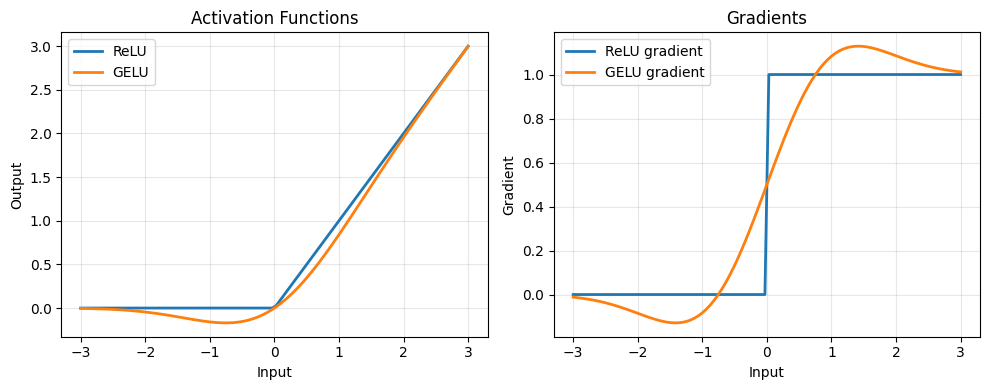

In [18]:
d_model = 128

ffn_relu = FeedForward(d_model, activation='relu')
ffn_gelu = FeedForward(d_model, activation='gelu')

x = torch.randn(2,10, d_model)   # [batch=2, seq=10, features=128]

out_relu = ffn_relu(x)
out_gelu = ffn_gelu(x)

# Visualization
x_test = torch.linspace(-3,3, 100)
relu_out = F.relu(x_test)
gelu_out = F.gelu(x_test)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(x_test, relu_out, label='ReLU', linewidth=2)
plt.plot(x_test, gelu_out, label='GELU', linewidth=2)
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Activation Functions')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2) # Derivatives
relu_grad = (x_test > 0).float()  # ReLU gradient: 0 if x<0, 1 if x>0 (undefined at 0)
x_test.requires_grad = True  # Enable gradient computation for GELU
gelu_out = F.gelu(x_test)
gelu_grad = torch.autograd.grad(gelu_out.sum(), x_test, create_graph=True)[0]  # Compute GELU gradient via autograd

plt.plot(x_test.detach(), relu_grad, label='ReLU gradient', linewidth=2)  # Step function
plt.plot(x_test.detach(), gelu_grad.detach(), label='GELU gradient', linewidth=2)  # Smooth S-curve
plt.xlabel('Input')
plt.ylabel('Gradient')
plt.title('Gradients')  # GELU has non-zero gradients for negative inputs (helps with dead neurons)
plt.legend()
plt.grid(True, alpha=0.3)



plt.tight_layout()
plt.show()

#Layer Normalization with Numpy

In [45]:
class LayerNormNumPy:
  def __init__(self, d_model, eps=1e-5):
    self.d_model = d_model # Channels
    self.eps = eps # Small constant for numerical stability

    # Learnable params
    self.gamma = np.ones(d_model)
    self.beta  = np.zeros(d_model)

  def forward(self, x):
    """ Normalize over last dimetnsion"""

    # Compute mean and std
    mean = np.mean(x, axis=-1, keepdims=True) # axis=-1 apply along last dim (rows), keepdims mantain dimensionality for broadcasting
    var = np.var(x, axis=-1, keepdims=True)
    std = np.sqrt(var + self.eps) # epsilon brings num stability

    print(f"Mean shape: {mean.shape}, first 3 values: {mean.flat[:3].round(3)}\n")
    print(f"Std shape: {std.shape}, first 3 values: {std.flat[:3].round(3)}\n")


    # Normalize
    x_norm = (x-mean)/std

    # Scale and shift
    output = self.gamma * x_norm + self.beta

    print("output = self.gamma * x_norm + self.beta \n")
    print(f"output {output} =\n gamma {self.gamma} * \n x_norm{x_norm.ravel()} \n+ beta {self.beta} ")


    return(output)

In [128]:
d_model = 8
x = np.random.randn(2, 4, d_model) * 5 + 2  # Non-normalized input

# Numpy implementation
ln_numpy = LayerNormNumPy(d_model)
out_numpy = ln_numpy.forward(x)

# Same but with pyTorch
ln_torch = nn.LayerNorm(d_model)
x_torch = torch.tensor(x, dtype=torch.float32)
out_torch = ln_torch(x_torch)

print(f"\nInput stats - Mean: {x.mean():.3f}, Std: {x.std():.3f}")
print(f"Numpy output stats - Mean: {out_numpy.mean():.3f}, Std: {out_numpy.std():.16f}")
print(f"PyTorch output stats - Mean: {out_torch.mean():.3f}, Std: {out_torch.std():.16f}")

print(f"{'PyTorch' if (abs(1-out_torch.std().item()) < abs(1-out_numpy.std())) else 'NumPy'} std closest to 1.0")

Mean shape: (2, 4, 1), first 3 values: [1.018 2.496 5.96 ]
Std shape: (2, 4, 1), first 3 values: [4.576 5.357 5.264]

Input stats - Mean: 1.696, Std: 4.766
Numpy output stats - Mean: -0.000, Std: 0.9999997031524236
PyTorch output stats - Mean: 0.000, Std: 1.0079050064086914
NumPy std closest to 1.0
